# Recognizing Named Entites Using CoNLL Tags and GloVe Embeddings
#### By Jonathan L. Moran (jo6155mo-s@student.lu.se)
From the EDAN95 - Applied Machine Learning course given at Lunds Tekniska Högskola (LTH) | Ht2 2019.

## Introduction
What is covered in this post:
*   Named entity recognition (NER)
*   Cosine similarity 
*   Word Representation
*   Contextual Word Representation
*   Training a Simple RNN and Bi-directional LSTM Model

Named entity recognition (abbreviated NER) is the task of _identifying_ and _categorising_ key information (called _entities_) in text. An entity is a word or string of words that have a categorical assignment. Possible entites include _Person_, _Organization_, _Time_, _Location_, etc.

In this article, we will be performing two major tasks:
1.   Recognising named entities in text.
2.   Predicting the corresponding NER tags of a tag set.

Before we dive into the code, let's first ask ourselves this–_why is this task important?_ Well, to begin with, named entity recognition is a non-trivial problem. This is because of the fact that a lot of entities, such as names or organizations, are simply made-up. In other words, we don’t have any prior knowledge of these entities. Such a dataset may not exist, or could simply be too computationally expensive to utilize. Thus, we need a model that will extract contextual information from a sentence, just like humans do.

NER is suitable for any situation where a high-level overview of large text is helpful. Some practical examples of this are:
*   Human resources– summarising applicants' CVs, parsing employee reviews/complaints.
*   Customer support– categorising complaints and help guides, filtering by keywords.
*   Health care– extracting important information from medical records.
and the list goes on...

## Programming
We will be using the famous [CoNLL2003 task](http://www.cnts.ua.ac.be/conll2003/ner/) data set to perform named entity recognition. This is a well known data set consisting of many, many tagged entities. The entity categories contained the CoNLL2003 task range from locations (e.g., roads, regions, public/commercial places, abstract places) to organizations (e.g., companies, brands, political movements, named collections of people) and persons (e.g. first/middle/last names, animals, aliases). A miscellaneous category includes words/word phrases not otherwise inferred (e.g., religions, nationalities, events, media titles, etc). If you are curious, a full list of tags with associated categories can be found [here](https://blog.myassignmenttutor.com/articleblog/conll-2003-list-of-tags-with-associated-categories-of-names/).

In [2]:
import os

In [3]:
!pip install regex

In [4]:
# Compute the F1-score (harmonic mean of the precision and recall).
!pip install conlleval
import conlleval

### Collecting a Dataset

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
BASE_DIR = '../src/'

In [7]:
### From P. Nugues' datasets.py

In [8]:
# import datasets
def load_conll2003_en():
    """
    Load the CoNLL2003 datasets and split into sentences. 
    """
    train_file = BASE_DIR + 'NER-data/eng.train'
    dev_file = BASE_DIR + 'NER-data/eng.valid'
    test_file = BASE_DIR + 'NER-data/eng.test'
    column_names = ['form', 'ppos', 'pchunk', 'ner']
    train_sentences = open(train_file, encoding='utf8').read().strip()
    dev_sentences = open(dev_file, encoding='utf8').read().strip()
    test_sentences = open(test_file, encoding='utf8').read().strip()
    return train_sentences, dev_sentences, test_sentences, column_names

In [9]:
### From P. Nugues' conll_dictorizer.py

In [10]:
# import CoNLLDictorizer, Token
"""
CoNLL 2009 file readers and writers for the parts of speech.
Version with a class modeled as a vectorizer
"""
__author__ = "Pierre Nugues"
import re

class Token(dict):
    pass


class CoNLLDictorizer:

    def __init__(self, column_names, sent_sep='\n\n', col_sep=' +'):
        self.column_names = column_names
        self.sent_sep = sent_sep
        self.col_sep = col_sep

    def fit(self):
        pass

    def transform(self, corpus):
        corpus = corpus.strip()
        sentences = re.split(self.sent_sep, corpus)
        return list(map(self._split_in_words, sentences))

    def fit_transform(self, corpus):
        return self.transform(corpus)

    def _split_in_words(self, sentence):
        rows = re.split('\n', sentence)
        return [Token(dict(zip(self.column_names,
                               re.split(self.col_sep, row))))
                for row in rows]

#### Using the CoNLL 2003 dataset
##### A local copy of the licensed dataset was provided in the `/usr/local/cs/EDAN95/datasets/NER-data` folder (access granted for LTH students).

This is the 20030423 release of the data for the CoNLL-2003 shared 
task.

In [12]:
train_sentences, dev_sentences, test_sentences, column_names = load_conll2003_en()

In [13]:
train_sentences[100]

'I'

In [14]:
test_sentences[100]

'I'

In [15]:
conll_dict = CoNLLDictorizer(column_names, col_sep=' +')
train_dict = conll_dict.transform(train_sentences)
dev_dict = conll_dict.transform(dev_sentences)
test_dict = conll_dict.transform(test_sentences)

Let's look at the first two examples in our train data:

In [16]:
print(train_dict[0])

[{'form': '-DOCSTART-', 'ppos': '-X-', 'pchunk': 'O', 'ner': 'O'}]


In [17]:
print(train_dict[1])

[{'form': 'EU', 'ppos': 'NNP', 'pchunk': 'I-NP', 'ner': 'I-ORG'}, {'form': 'rejects', 'ppos': 'VBZ', 'pchunk': 'I-VP', 'ner': 'O'}, {'form': 'German', 'ppos': 'JJ', 'pchunk': 'I-NP', 'ner': 'I-MISC'}, {'form': 'call', 'ppos': 'NN', 'pchunk': 'I-NP', 'ner': 'O'}, {'form': 'to', 'ppos': 'TO', 'pchunk': 'I-VP', 'ner': 'O'}, {'form': 'boycott', 'ppos': 'VB', 'pchunk': 'I-VP', 'ner': 'O'}, {'form': 'British', 'ppos': 'JJ', 'pchunk': 'I-NP', 'ner': 'I-MISC'}, {'form': 'lamb', 'ppos': 'NN', 'pchunk': 'I-NP', 'ner': 'O'}, {'form': '.', 'ppos': '.', 'pchunk': 'O', 'ner': 'O'}]


And the first sentence in our dev data set:

In [18]:
print(dev_dict[1])

[{'form': 'CRICKET', 'ppos': 'NNP', 'pchunk': 'I-NP', 'ner': 'O'}, {'form': '-', 'ppos': ':', 'pchunk': 'O', 'ner': 'O'}, {'form': 'LEICESTERSHIRE', 'ppos': 'NNP', 'pchunk': 'I-NP', 'ner': 'I-ORG'}, {'form': 'TAKE', 'ppos': 'NNP', 'pchunk': 'I-NP', 'ner': 'O'}, {'form': 'OVER', 'ppos': 'IN', 'pchunk': 'I-PP', 'ner': 'O'}, {'form': 'AT', 'ppos': 'NNP', 'pchunk': 'I-NP', 'ner': 'O'}, {'form': 'TOP', 'ppos': 'NNP', 'pchunk': 'I-NP', 'ner': 'O'}, {'form': 'AFTER', 'ppos': 'NNP', 'pchunk': 'I-NP', 'ner': 'O'}, {'form': 'INNINGS', 'ppos': 'NNP', 'pchunk': 'I-NP', 'ner': 'O'}, {'form': 'VICTORY', 'ppos': 'NN', 'pchunk': 'I-NP', 'ner': 'O'}, {'form': '.', 'ppos': '.', 'pchunk': 'O', 'ner': 'O'}]


Great! We have successfully obtained our CoNLL2003 data, which we will used to train and validate our NER tag model. Let's move on to the next step in our pipeline–obtaining _word representations_. We will accomplish this using a set of pre-trained word vectors.

### Collecting the Embeddings
In this segment, we will be using a set of pre-trained word embeddings from the [GloVe](https://nlp.stanford.edu/projects/glove/) unsupervised learning algorithm for obtaining vector representations for words. But wait–_what is a word embeddding?_ Well, from the words of [Samarth Agrawal](https://towardsdatascience.com/what-the-heck-is-word-embedding-b30f67f01c81), a word embedding is a collective term used to describe models that learned to map a set of words or phrases in a vocabulary to vectors of numerical values. In short, word embeddings are the result of a very simple method to represent a word in the vector form. 

Word embeddings are a class of techniques where individual words are represented as real-valued vectors in a predefined vector space. Furthermore, each word is mapped to one vector and the vector values are learned in a way that resembles a neural network (thanks for that definition, [Jason Brownlee](https://machinelearningmastery.com/what-are-word-embeddings/).

_1. Download the 'GloVe embeddings 6B' from https://nlp.stanford.edu/projects/glove/ and keep the `glove.6B.100d` vectors._

In [19]:
embedding_file = '../src/glove.6B.100d.txt'

_2. LTH students: you have a local copy of this script in `usr/local/cs/EDAN95/datasets/`_

_3. Write a function that reads GloVe embeddings and store them in a dictionary, where the `keys` will be the words and the `values`, the embeddings._

Luckily, [Pierre Nugues](https://cs.lth.se/pierre/) did most of the work in this step for us. Thanks, Pierre.

In [20]:
def read_embeddings(file):
  """
  Return the embeddings in the form of a dictionary (src:
  https://github.com/pnugues/edan95/blob/master/programs/4.2-nn-pos-tagger-embeddings.ipynb)

  :return: embeddings   the GloVe embeddings where `keys`=words, `values`=embeddings
  """
  embeddings = {}
  glove = open(file, encoding='utf8')
  for line in glove:
    values = line.strip().split()
    word = values[0]
    vector = np.array(values[1:], dtype='float32')
    embeddings[word] = vector
  glove.close()

  return embeddings

In [21]:
embeddings_dict = read_embeddings(embedding_file)
embedded_words = sorted(list(embeddings_dict.keys()))

Here's what we got from our `read_embeddings` method:

In [22]:
print('Found %s word vectors' % len(embeddings_dict))

Found 400000 word vectors


In [23]:
print('Found %s embedding words' % len(embedded_words))

Found 400000 embedding words


At first glance, you can see that we obtained a _ton_ of embeddings from the GloVe data set. `400000` unique words, to be exact. And because these are feature vectors, we see that there are also `400000` vectors, one for each word.

##### 4. Using a cosine similarity, compute the 5 closest words to the words _table_, _france_, and _sweden_
In this example, we will be computing the _cosine similarity_ between each embedding. This serves as a measure of similarity between two vectors by computing the angle between them and determining whether the two vectors are pointing in roughly the same direction. We won't go into the details of this computation, since it's readily available to us using `sklearn`, but many explanations are just a click away.

In [24]:
from sklearn.metrics.pairwise import cosine_similarity
from operator import itemgetter

In [25]:
def closest_neighbors(glove_dict):
  #word_embedding = embeddings_idx[word]
  neighbors = {}
  neighbors2 = {}
  neighbors3 = {}
  #print(word_embedding)
  #print(neighbors)
  
  for i in glove_dict:
    val = round(cosine_similarity([glove_dict['table'], glove_dict[i]])[0][1], 4)
    if val > 0:
      neighbors[i] = val
    val2 = round(cosine_similarity([glove_dict['france'], glove_dict[i]])[0][1], 4)
    if val2 > 0:
      neighbors2[i] = val2
    val3 = round(cosine_similarity([glove_dict['sweden'], glove_dict[i]])[0][1], 4)
    if val3 > 0:
      neighbors3[i] = val3

  pair_list = []
  for k,v in sorted(neighbors.items(), key=itemgetter(1)):
    pair_list.append(k)
  print('Closest 5 words to "table": ', pair_list[-5:])

  pair_list = []
  for k,v in sorted(neighbors2.items(), key=itemgetter(1)):
    pair_list.append(k)
  print('Closest 5 words to "france": ', pair_list[-5:])

  pair_list = []
  for k,v in sorted(neighbors3.items(), key=itemgetter(1)):
    pair_list.append(k)
  print('Closest 5 words to "sweden": ', pair_list[-5:])

In [26]:
closest_neighbors(embeddings_dict)

Closest 5 words to "table":  ['room', 'bottom', 'place', 'tables', 'table']
Closest 5 words to "france":  ['spain', 'britain', 'french', 'belgium', 'france']
Closest 5 words to "sweden":  ['netherlands', 'finland', 'norway', 'denmark', 'sweden']


As the above described, we used cosine similarity to compute the 5 closest words to _table_, _france_ and _sweden_. The results look pretty good! The words "bottom" and "table" seem to imply a context-specific (and rather strange) co-occurence. Also, it seems odd that the "netherlands" is associated with the Scandinavian country "sweden", but nontheless–GloVe embeddings seem like a great place to start with encoding semantic understanding in our model. For the extra smart ones out there, consider improving your own NER model by fine-tuning contextual word representaions (popularised by models like BERT, ELMo, GPT-2). More on that [here](http://ai.stanford.edu/blog/contextual/).

### Extracting the $X$ and $Y$ Lists of Symbols

#### Reading the Corpus and Building Indices
In this step we will be creating a vocabulary composed of all the words in the CoNLL and GloVe data sets. We'll use a few methods provided to us by Pierre Nugues to accomplish this task.

You will read the corpus with programs available from https://github.com/pnugues/edan95. These programs will enable you to load the files in the form of a list of dictionaries.

_1. Write a function that for each sentence returns the *x* and *y* lists of symbols consisting of words and NER tags._

Some datasets you may find on the web use a different NER tagset, where `I-` is replaced with `B-`, like `B-ORG` instead of `I-ORG`. This will not change your results.

In [27]:
def build_sequences(corpus_dict, key_x='form', key_y='ner', tolower=True):
  """
  Creates sequences from a list of dictionaries
  :param corpus_dict:
  :param key_x:
  :param key_y:
  :return:
  """
  X = []
  Y = []
  
  for sentence in corpus_dict:
    x = []     # list of symbols containing words
    y = []     # list of symbols containing NER tags
    
    for word in sentence:
      x += [word[key_x]]
      y += [word[key_y]]
    if tolower:
      x = list(map(str.lower, x))
    X += [x]
    Y += [y]

  return X, Y

_2. Apply this function to your datasets so you create **X** and **Y** lists of lists consisting of words and NER tags._

In [28]:
X_train, Y_train = build_sequences(train_dict)
X_test, Y_test = build_sequences(test_dict)
X_dev, Y_dev = build_sequences(dev_dict)

_For the second sentence of the training set, you should have:_
```
x = ['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.']
y = ['I-ORG', 'O', 'I-MISC', 'O', 'O', 'O', 'I-MISC', 'O', 'O']
```

In [29]:
print('x =', X_train[1])
print('y =', Y_train[1])

x = ['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.']
y = ['I-ORG', 'O', 'I-MISC', 'O', 'O', 'O', 'I-MISC', 'O', 'O']


Look at that–it matches!


Let's also take a look at the second sentence of the dev set:

In [30]:
print('x =', X_dev[1])
print('y =', Y_dev[1])

x = ['cricket', '-', 'leicestershire', 'take', 'over', 'at', 'top', 'after', 'innings', 'victory', '.']
y = ['O', 'O', 'I-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


_3. Create a vocabulary of all the words observed in the training set and the words in GloVe. You should find 402,595 different words._

In [31]:
def extract_words(X_dict, Y_dict):
  # Extracting the words in the CoNLL data set
  vocabulary_words = sorted(list(
      set([word for sentence in X_dict for word in sentence])))

  # Extracting the NER tags in the GloVe tagset
  ner = sorted(list(
      set([ner for sentence in Y_dict for ner in sentence])))
  
  print('NER tagset: ', ner)

  return vocabulary_words, ner

In [32]:
vocabulary_words, ner = extract_words(X_train, Y_train)

NER tagset:  ['B-LOC', 'B-MISC', 'B-ORG', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O']


Let's preview the words in our new vocabulary. We will consider a range of 10 words that begin with the letter 'A'.

In [33]:
def create_dict(vocabulary_words, embeddings_dict):
  """
  Creates a dictionary of unique words in the CoNLL and GloVe embeddings data sets
  Each word has a padding_length of 2, such that:
    - index 0 is the padding symbol and,
    - index 1 is the unknown words symbol

  :param vocabulary_words:    the set of unique words in CoNLL data set
  :param embeddings_words:    the set of unique NER tags in GloVe data set
  :return vocabulary_words:   the set of unique words in entire vocabulary (GloVe and CoNLL)
  :return cnt_uniq:           the number of unique words (plus padding symbols)
  """
  padding_length = 2

  embeddings_words = embeddings_dict.keys()
  print('Words in GloVe:',  len(embeddings_dict.keys()))

  vocabulary_words = sorted(list(set(vocabulary_words + list(embeddings_words))))

  cnt_uniq = len(vocabulary_words) + padding_length
  print('# unique words in the vocabulary: embeddings and corpus:', cnt_uniq)

  return vocabulary_words, cnt_uniq

In [34]:
vocabulary_words, cnt_uniq = create_dict(vocabulary_words, embeddings_dict)

Words in GloVe: 400000
# unique words in the vocabulary: embeddings and corpus: 402597


By this step, you should note that we have a new vocabulary consisting of CoNLL + GloVe words and NER tags. We've added 2597 words to our GloVe embeddings dictionary, leaving us with a total of 402597 unique words to work with.

_4. Create indices and inverted indices for all the words and the NER: i.e. you will associate each word with a number. You will use index 0 for the padding symbol and 1 for unknown words._

For clarification, an _inverted index_ is an index data structure storing a mapping from content, such as words or numbers, to its location in a document or set of documents. An advantage of using an inverted index is that it allows for fast full-text searches, but comes at the cost of high storage overhead and maintence costs on update, delete and insert (more on that [here](https://www.geeksforgeeks.org/inverted-index/)).

In [35]:
from sklearn.feature_extraction import DictVectorizer

In [36]:
def map_idx(vocabulary_words, ner, X_dict, Y_dict):
  """
  Maps the list of words (or NER tag lists) to a parallelly-sequenced index

  :param vocabulary_words:   the list of lists containing CoNLL words
  :param ner:                the list of lists containing GloVe embeddings
  :param X_dict:             the sequenced list of dictionaries containing vocabulary words
  :param Y_dict:             the sequenced list of dictionaries containing GloVe embeddings
  :return X_idx:             the parallelly-sequenced indexes mapping unique words to indices
  :return word_idx:          the padded index containing unique words in vocabulary
  :return Y_idx:             the parallelly-sequenced indexes mapping unique tags to indices
  :return ner_idx:           the padded index containing unique tags in vocabulary
  """
  # We keep indexes 0,1 for padding and unknown word symbols
  idx_word = dict(enumerate(vocabulary_words, start=2))
  idx_ner = dict(enumerate(ner, start=2))

  word_idx = {v: k for k, v in idx_word.items()}
  ner_idx = {v: k for k, v in idx_ner.items()}

  X_idx = []
  for x in X_dict:
    # We map the unknown words to one
    x_idx = list(map(lambda x: word_idx.get(x, 1), x))
    X_idx += [x_idx]
  
  Y_idx = []
  for y in Y_dict:
    # We map the unknown words to one
    y_idx = list(map(lambda y: ner_idx.get(y, 1), y))
    Y_idx += [y_idx]
  
  return X_idx, word_idx, Y_idx, ner_idx

In [37]:
X_idx, word_idx, Y_idx, ner_idx = map_idx(vocabulary_words, ner, X_train, Y_train)
X_dev_idx, word_dev_idx, Y_dev_idx, ner_dev_idx = map_idx(vocabulary_words, ner, X_dev, Y_dev)

In [38]:
print('Second sentences of X_idx, word indices', X_idx[:4])
print('Second sentences of Y_idx, NER indices', Y_idx[:4])

Second sentences of X_idx, word indices [[935], [142143, 307143, 161836, 91321, 363368, 83766, 85852, 218260, 936], [284434, 79019], [86920, 15423]]
Second sentences of Y_idx, NER indices [[9], [7, 9, 6, 9, 9, 9, 6, 9, 9], [8, 8], [5, 9]]


In [39]:
print('Second sentences of X_dev_idx, word indices', X_dev_idx[:4])
print('Second sentences of Y_dev_idx, NER indices', Y_dev_idx[:4])

Second sentences of X_dev_idx, word indices [[935], [113351, 679, 221875, 354360, 275584, 63471, 364505, 49150, 192163, 381011, 936], [227217, 15431], [388337, 190955, 53074, 285387, 334414, 364408, 154113, 153033, 26724, 271939, 155673, 62067, 221875, 72732, 339658, 89620, 55656, 192163, 56102, 27037, 315734, 190291, 370791, 119532, 363368, 354360, 275584, 63471, 359698, 176975, 270183, 359698, 112003, 98068, 936]]
Second sentences of Y_dev_idx, NER indices [[9], [9, 9, 7, 9, 9, 9, 9, 9, 9, 9, 9], [5, 9], [6, 6, 9, 8, 8, 9, 9, 9, 9, 9, 9, 9, 7, 9, 7, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]]


### Building the Embeddings Matrix

This matrix will be used to train our model on the vocabulary we constructed earlier. An embeddings matrix consists of word embeddings represented as a dense real-valued low dimensional matrix. Each row of the matrix is associated with a word in our vocabulary and each column in the matrix represents a latent feature. In our use case, we will consider the dimensionality of each embedding `N` to be of length `100`. That is, each unique word `M` in our vocabulary will have `100` features (elements) in every 1-D vertical array. According to our specification below, we will initialise these 100 elements to be random values. 

_1. Create a matrix of dimensions `(M, N)`, where `M` will be the size of the vocabulary (the unique words in the training set and the words in GloVe), and `N` will be the dimension of the embeddings._
* The padding symbol and the unknown word symbol will be part of the vocabulary.
* The shape of your matrix should be `(402597, 100)`. Initialise it with random values.

In [40]:
def create_embeddings_matrix(vocabulary_words, embeddings_dict, word_idx):
  """
  Create an embeddings matrix of size (M,N) where 
    M = size of vocabulary_words, and 
    N = dimension of embeddings

  :param vocabulary_words:    the unique words in the training set and in GloVe
  :param embeddings_dict:     the GloVe embeddings
  :param word_idx:            the unique words 
  :return embedding_matrix:   the MxN matrix of M vocabulary words and N embeddings
  """
  EMBEDDING_DIM = 100
  rdstate = np.random.RandomState(1234567)
  # random = np.random.random((len(vocabulary_words)+2, EMBEDDING_DIM))
  embedding_matrix = rdstate.uniform(-0.05, 0.05,
                                     (len(vocabulary_words) + 2,
                                      EMBEDDING_DIM))

  for word in vocabulary_words:
    if word in embeddings_dict:
      # If the words are in the embeddings, we fill them with a value
      embedding_matrix[word_idx[word]] = embeddings_dict[word]

  return embedding_matrix

_2. Fill the matrix with the GloVe embeddings when available. You will use the indices from the previous section._

In [41]:
embedding_matrix = create_embeddings_matrix(vocabulary_words, embeddings_dict, word_idx)

In [42]:
print('Shape of embedding matrix:', embedding_matrix.shape)
print('Embedding of table', embedding_matrix[word_idx['table']])
print('Embedding of the padding symbol, idx 0, random numbers', 
      embedding_matrix[0])

Shape of embedding matrix: (402597, 100)
Embedding of table [-0.61453998  0.89692998  0.56770998  0.39102    -0.22437     0.49035001
  0.10868     0.27410999 -0.23833001 -0.52152997  0.73550999 -0.32653999
  0.51304001  0.32415    -0.46709001  0.68050998 -0.25497001 -0.040484
 -0.54417998 -1.05480003 -0.46691999  0.23557     0.31233999 -0.34536999
  0.14793    -0.53745002 -0.43215001 -0.48723999 -0.51019001 -0.90509999
 -0.17918999 -0.018376    0.09719    -0.31623     0.75120002  0.92236
 -0.49965     0.14036    -0.28296    -0.97443002 -0.0094408  -0.62944001
  0.14711    -0.94375998  0.0075222   0.18565001 -0.99172002  0.072789
 -0.18474001 -0.52901     0.38995001 -0.45677    -0.21932     1.37230003
 -0.29635999 -2.2342     -0.36667001  0.04987     0.63420999  0.53275001
 -0.53955001  0.31398001 -0.44698    -0.38389     0.066668   -0.02168
  0.20558     0.59456003 -0.24891999 -0.52794999 -0.3761      0.077104
  0.75221997 -0.2647     -0.0587      0.67540997 -0.16559    -0.49278
 -0.26

Now that we have constructed our vocabulary embeddings matrix, we will begin to conduct our final step in the pre-processing stage so we can train a model to perform our desired task. In case you have forgotten by now, that is to create a NER model to locate and classify named entities in text.

### Creating the **X** and **Y** Sequences

You will now create the input and output sequences with numerical indices.

_1. Convert the **X** and **Y** lists of symbols in lists of numbers using the indices you created._

_2. Pad the sentences using the `pad_sequences` function. As maximum length and `maxlen` argument, you will use 150 or greater. What matters is that you have a length that is larger than the maximum length you observed in your training and development corpora._

For further clarification, the `pad_sequences` function will pad each sentence with the value `0` to a specific length, in our case, that is `150`.

In [43]:
from keras.preprocessing.sequence import pad_sequences

In [44]:
MAX_SEQUENCE_LEN=150

In [45]:
# Padding the training set with maxlen of GloVe data set
X = pad_sequences(X_idx, maxlen=MAX_SEQUENCE_LEN)
Y = pad_sequences(Y_idx, maxlen=MAX_SEQUENCE_LEN)

In [46]:
# The first sentence of our vocabulary index, padded with maxlen of GloVe data set
print(X[0])
# The first sequence of embeddings, padded with maxlen of GloVe data set
print(Y[0])

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0 935]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 9]


In [47]:
from keras.utils import to_categorical

The `to_categorical` function returns a matrix of binary values where each row equals the length of the input vector and the number of columns corresponds to the number of classes.

In [48]:
# The number of NER tags and 0 (padding symbol)
Y_train_cat = to_categorical(Y, num_classes=len(ner) + 2)
#print(Y_train_cat)

In [49]:
# Generating the test set
X_test_idx, word_test_idx, Y_test_idx, ner_test_idx = map_idx(vocabulary_words, ner, X_test, Y_test)

# Padding the test set with maxlen of GloVe data set
X_test_padded = pad_sequences(X_test_idx, maxlen=MAX_SEQUENCE_LEN)
Y_test_padded = pad_sequences(Y_test_idx, maxlen=MAX_SEQUENCE_LEN)

# 0 (padding), 1 (missing word)
Y_test_cat = to_categorical(Y_test_padded, num_classes=len(ner) + 2)

In [50]:
print('Shape of X_test set:', X_test_padded.shape)

Shape of X_test set: (3684, 150)


In [51]:
print('Shape of Y_test set:', Y_test_cat.shape)

Shape of Y_test set: (3684, 150, 10)


_3. Do the same for the development set._

In [52]:
# Padding the dev set with maxlen of GloVe data set
X_dev_padded = pad_sequences(X_dev_idx, maxlen=MAX_SEQUENCE_LEN)
Y_dev_padded = pad_sequences(Y_dev_idx, maxlen=MAX_SEQUENCE_LEN)

In [53]:
# The first sentence of our dev vocabulary index, padded with maxlen of GloVe data set
print(X_dev_padded[0])

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0 935]


In [54]:
# The first sequence of dev embeddings, padded with maxlen of GloVe data set
print(Y_dev_padded[0])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 9]


In [55]:
# The number of NER tags (2 missing) and 0 (padding symbol) in our dev set
Y_dev_cat = to_categorical(Y_dev_padded, num_classes=len(ner) + 2)
print(Y_dev_cat[0])

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [56]:
print('Shape of X_dev set:', X_dev_padded.shape)

Shape of X_dev set: (3466, 150)


In [57]:
print('Shape of Y_dev set:', Y_dev_cat.shape)

Shape of Y_dev set: (3466, 150, 10)


If you have made it this far– congratulations! We finished preparing our data. That was a lot of steps, so let's recap. We:
1.   Collected a data set using both CoNLL2003 and GloVe embeddings data.
2.   Constructed a vocabulary of all unique words in each.
3.   Obtained parallely-sequenced and inverted indices.
4.   Generated sequenced X and Y data using the keras `to_categorical()` method.

### Building a Simple Reccurent Neural Network

We will first be training a `keras simpleRNN` model on our data. While simple RNN models can classify the input sequence taking into account the long time dependencies, they face the problem of vanishing gradients ([Y Benigo, 1994](https://ieeexplore.ieee.org/document/279181)). To solve this problem, we will be using another RNN architecture known as the Long Short-Term Memory (LSTM). The LSTM, namely the bi-directional LSTM, is a widely-accepted architecture for performing NER. However, let's start with this simple model so we can show you some improved results in the later part of this notebook.

In [58]:
from keras import models, layers
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import StandardScaler
from keras import utils
from keras.layers import SimpleRNN, Dense, Embedding
from keras.models import load_model
import math
import bisect
import operator

_1. Create a simple recurrent network and train a model with the training set. As layers, you will use `Embedding`, `SimpleRNN`, and `Dense`._

In [59]:
EMBEDDING_DIM = 100
OPTIMIZER = 'rmsprop'
EPOCHS = 10
BATCH_SIZE = 128
NB_CLASSES = len(ner)

Relative classification accuracy is high (trainable == False)

In [60]:
model = models.Sequential()
model.add(layers.Embedding(len(vocabulary_words) + 2,
                           EMBEDDING_DIM,
                           mask_zero=True))
model.layers[0].set_weights([embedding_matrix])
# The default is True
model.layers[0].trainable = True
model.add(SimpleRNN(EMBEDDING_DIM, return_sequences=True))
model.add(Dense(units=NB_CLASSES+2, activation='softmax'))

_2. Compile and fit your network. You will report the training and validation losses and accuracies and comment on the possible overfit._

In [61]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         40259700  
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, None, 100)         20100     
_________________________________________________________________
dense (Dense)                (None, None, 10)          1010      
Total params: 40,280,810
Trainable params: 40,280,810
Non-trainable params: 0
_________________________________________________________________


In [62]:
trained = True
if trained == False:
    history = model.fit(X, Y_train_cat, 
                        epochs=EPOCHS, 
                        batch_size=BATCH_SIZE,
                        validation_data=(X_dev_padded, Y_dev_cat)
                       )

Epoch 1/10
118/118 [==============================] - 44s 365ms/step - loss: 0.0641 - acc: 0.8083 - val_loss: 0.0221 - val_acc: 0.9357
Epoch 2/10
118/118 [==============================] - 43s 361ms/step - loss: 0.0169 - acc: 0.9436 - val_loss: 0.0180 - val_acc: 0.9464
Epoch 3/10
118/118 [==============================] - 42s 351ms/step - loss: 0.0125 - acc: 0.9574 - val_loss: 0.0174 - val_acc: 0.9455
Epoch 4/10
118/118 [==============================] - 40s 338ms/step - loss: 0.0105 - acc: 0.9648 - val_loss: 0.0137 - val_acc: 0.9601
Epoch 5/10
118/118 [==============================] - 41s 345ms/step - loss: 0.0088 - acc: 0.9695 - val_loss: 0.0142 - val_acc: 0.9567
Epoch 6/10
118/118 [==============================] - 44s 370ms/step - loss: 0.0077 - acc: 0.9732 - val_loss: 0.0132 - val_acc: 0.9602
Epoch 7/10
118/118 [==============================] - 41s 345ms/step - loss: 0.0070 - acc: 0.9761 - val_loss: 0.0136 - val_acc: 0.9571
Epoch 8/10
118/118 [==============================] - 4

In [63]:
if trained == False:
    model.save_weights('model1.model')
else:
    model.load_weights('model1.model')

#### Visualising the training metrics
Now that we've trained our model, we want to visualise the model's training and validation accuracy.

In [64]:
import matplotlib.pyplot as plt

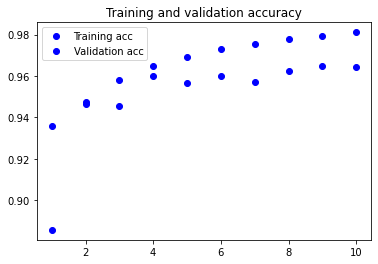

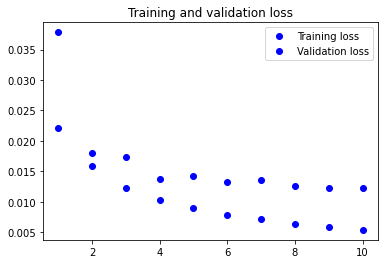

In [65]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'bo', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()


plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

_3. Apply your network to the test set and report the accuracy you obtained. You will use the `evaluate` method._

In [66]:
# Evaluates with the padding symbol
test_loss, test_acc = model.evaluate(X_test_padded, Y_test_cat)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

116/116 [==============================] - 2s 20ms/step - loss: 0.0145 - acc: 0.9503
Test loss: 0.014512376859784126
Test accuracy: 0.950285017490387


#### Evaluating your System

_1. Use the predict method to predict the tags of the whole test set._

In [67]:
# Evaluating on all the test corpus
y_pred = model.predict(X_test_padded)
y_preds = np.argmax(y_pred, axis=2)

In [68]:
# Remove padding
Y_test_ = [y[y != 0.] for y in np.argmax(Y_test_cat, axis = 2)]
Y_pred_ = [y_hat[y != 0.] for y, y_hat in zip(np.argmax(Y_test_cat, axis = 2), y_preds)]

In [69]:
# Compare first predicted sentence tags to actual
print("Predicted:", Y_pred_[1])
print("Actual   :", Y_test_[1])

Predicted: [9 9 5 9 9 9 9 5 9 9 9 9]
Actual   : [9 9 5 9 9 9 9 8 9 9 9 9]


_2. Write your results in a file, where the two last columns will be the hand-annotated tag and the predicted tag. The fields must be separated by a space and each line must end with a new line: `\n`._

Written by Jonas Lundgren, link [here](https://github.com/LurreMcFly/edan95/blob/master/Lab4/lab4.ipynb).

In [70]:
def save(file, corpus_dict, ner, y, y_pred):
    
    with open(file, 'w', encoding='utf8') as f_out:
        for i, sentence in enumerate(corpus_dict):
            sentence_lst = []
            for j, row in enumerate(sentence):
                items = str(row.get('form')) + ' ' + str(ner[y[i][j]- 2]) + ' ' + str(ner[y_pred[i][j] - 2])
                sentence_lst += items + '\n'
            sentence_lst += '\n'
            f_out.write(''.join(sentence_lst))

In [71]:
# Writing results to file
save("output1.txt", test_dict, ner, Y_test_, Y_pred_)

##### 3. Apply conlleval to your output. Report the F1 result.

In [72]:
lines = open("output1.txt", encoding='utf8').read().splitlines()
res = conlleval.evaluate(lines)
improved_score = res['overall']['chunks']['evals']['f1']
print("F1 score:", improved_score)

F1 score: 0.7279680166869459


#### Building a LSTM Network
While the above model produces pretty good results, we want to consider using a Long Short-Term Memory (LSTM) model to address the problem of vanishing gradients. The type of LSTM we will be using is called a `Bidirectional` layer because information from its inputs will be preserved from both directions, _past to future_ and _future to past_. The use of the two hidden states combined results in better performance by allowing the model to learn both past and future contexts of a word.



_1. Create a simple LSTM network and train a model with the train set. As layers, you will use `Embedding`, `LSTM`, and `Dense`._

In [73]:
from keras.layers import LSTM, Bidirectional

In [74]:
model2 = models.Sequential()
model2.add(layers.Embedding(len(vocabulary_words) + 2,
                           EMBEDDING_DIM,
                           mask_zero=True,
                           input_length=MAX_SEQUENCE_LEN))
# model.add(SimpleRNN(100, return_sequences=True))
# model.add(Bidirectional(SimpleRNN(100, return_sequences=True)))
model2.add(Bidirectional(LSTM(EMBEDDING_DIM, return_sequences=True)))
model2.add(Dense(units=NB_CLASSES+2, activation='softmax'))

model2.layers[0].set_weights([embedding_matrix])
# The default is True
model2.layers[0].trainable = True
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 100)          40259700  
_________________________________________________________________
bidirectional (Bidirectional (None, 150, 200)          160800    
_________________________________________________________________
dense_1 (Dense)              (None, 150, 10)           2010      
Total params: 40,422,510
Trainable params: 40,422,510
Non-trainable params: 0
_________________________________________________________________


_2. Compile and fit your network. You will report the training and validation losses and accuracies and comment on the possible overfit._

In [75]:
model2.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

In [76]:
trained = False
if trained == False:
    history = model2.fit(X, Y_train_cat, 
                         epochs=EPOCHS, 
                         batch_size=BATCH_SIZE,
                         validation_data=(X_dev_padded, Y_dev_cat))

Epoch 1/10
118/118 [==============================] - 107s 836ms/step - loss: 0.0555 - acc: 0.8288 - val_loss: 0.0204 - val_acc: 0.9388
Epoch 2/10
118/118 [==============================] - 101s 854ms/step - loss: 0.0155 - acc: 0.9504 - val_loss: 0.0134 - val_acc: 0.9608
Epoch 3/10
118/118 [==============================] - 112s 951ms/step - loss: 0.0102 - acc: 0.9658 - val_loss: 0.0123 - val_acc: 0.9629
Epoch 4/10
118/118 [==============================] - 141s 1s/step - loss: 0.0083 - acc: 0.9723 - val_loss: 0.0106 - val_acc: 0.9675
Epoch 5/10
118/118 [==============================] - 141s 1s/step - loss: 0.0066 - acc: 0.9782 - val_loss: 0.0109 - val_acc: 0.9675
Epoch 6/10
118/118 [==============================] - 132s 1s/step - loss: 0.0056 - acc: 0.9820 - val_loss: 0.0100 - val_acc: 0.9712
Epoch 7/10
118/118 [==============================] - 138s 1s/step - loss: 0.0043 - acc: 0.9855 - val_loss: 0.0097 - val_acc: 0.9708
Epoch 8/10
118/118 [==============================] - 125s 1

##### Saving model weights

In [77]:
if trained == False:
    model2.save_weights('model2.model')
else:
    model2.load_weights('model2.model')

##### Visualising the training metrics
Now that we've trained our model, we want to visualise the model's training and validation accuracy.

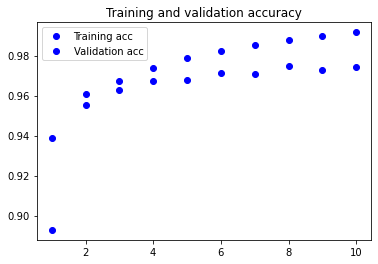

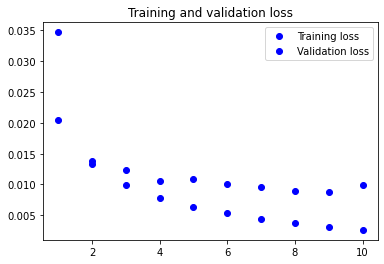

In [78]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'bo', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()


plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

_3. Apply your network to the test set and report the accuracy you obtained. You will use the `evaluate` method._

In [79]:
# Evaluates with the padding symbol
test_loss, test_acc = model2.evaluate(X_test_padded, Y_test_cat)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

116/116 [==============================] - 9s 78ms/step - loss: 0.0128 - acc: 0.9614
Test loss: 0.012847092002630234
Test accuracy: 0.9614280462265015


#### Evaluating your System

_1. Use the predict method to predict the tags of the whole test set._

In [80]:
y_pred = model2.predict(X_test_padded)
y_preds = np.argmax(y_pred, axis=2)

In [81]:
# Remove padding
Y_test_ = [y[y != 0.] for y in np.argmax(Y_test_cat, axis = 2)]
Y_pred_ = [y_hat[y != 0.] for y, y_hat in zip(np.argmax(Y_test_cat, axis = 2), y_preds)]

In [82]:
# Compare first predicted sentence tags to actual
print("Predicted:", Y_pred_[1])
print("Actual   :", Y_test_[1])

Predicted: [9 9 5 9 9 9 9 5 9 9 9 9]
Actual   : [9 9 5 9 9 9 9 8 9 9 9 9]


_2. Write your results in a file, where the two last columns will be the hand-annotated tag and the predicted tag. The fields must be separated by a space and each line must end with a new line: `\n`._

In [83]:
# Writing results to file
save("output2.txt", test_dict, ner, Y_test_, Y_pred_)

_3. Apply conlleval to your output. Report the F1 result._

In [84]:
lines = open("output2.txt", encoding='utf8').read().splitlines()
res = conlleval.evaluate(lines)
improved_score = res['overall']['chunks']['evals']['f1']
print("F1 score:", improved_score)

F1 score: 0.8097796883396023


So we were able to impove the test accuracy of our initial model 8.2% by adding a Bidirectional LSTM layer. No complaints there. But what if I told you we could go further with our improvisation? That's what we'll try to accomplish with our third and final model.

### Improving the Bidirectional LSTM
We've seen that making some minor adjustments to the way we define our model's architecture can have a pretty significant impact on test performance. To recap, we changed our `simpleRNN` layer to a `Bidirectional LSTM` layer, and, in line with _Y Benigo's_ research paper, we found that to be an overall improvement in accuracy on test set evaluation. Now, there's a few other parameters in this model that we can fine-tune for better performance.

##### Adding layers

Let's start with the first optimisation–changing our model architecture. Assume that we have an ideal configuration in mind. That is to say, we can expect great results by doing the following:
*   Adding an additional `Bidirectional LSTM` layer
*   Adding `Dropout` layers between our `Bidirectional LSTM` and `Dense` layers.
*   Adding a `Dense` layer with the `relu` activation function
If you want an explanation as to why the above layers improve our word embedding model performance, there's a short lecture from DeepLearning.AI's Natural Language Processing with Sequence Models course covering the use of `Dense` and `ReLu` layers [here](https://www.coursera.org/lecture/sequence-models-in-nlp/dense-and-relu-layers-AGDYm?utm_source=link&utm_medium=page_share&utm_content=vlp&utm_campaign=top_button).

_1. Create a LSTM network and train a model with the train set. As layers, you will use `Embedding`, `Bidirectional LSTM`, `Dropout` and `Dense`._

In [92]:
from keras.layers import Dropout

In [93]:
model3 = models.Sequential()
model3.add(layers.Embedding(len(vocabulary_words) + 2,
                           EMBEDDING_DIM,
                           mask_zero=True,
                           input_length=MAX_SEQUENCE_LEN))
model3.add(Bidirectional(LSTM(EMBEDDING_DIM, return_sequences=True)))
model3.add(Dropout(0.05))
model3.add(Bidirectional(LSTM(EMBEDDING_DIM, return_sequences=True)))
model3.add(Dropout(0.05))
model3.add(Dense(512, activation = 'relu'))
model3.add(Dropout(0.5))
model3.add(Dense(units=NB_CLASSES+2, activation='softmax'))

model3.layers[0].set_weights([embedding_matrix])

model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 150, 100)          40259700  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 150, 200)          160800    
_________________________________________________________________
dropout (Dropout)            (None, 150, 200)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 150, 200)          240800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 150, 200)          0         
_________________________________________________________________
dense_2 (Dense)              (None, 150, 512)          102912    
_________________________________________________________________
dropout_2 (Dropout)          (None, 150, 512)         

_2. Compile and fit your network. You will report the training and validation losses and accuracies and comment on the possible overfit._

In [94]:
model3.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['acc'])

In [95]:
trained = False
if trained == False:
    history = model3.fit(X, Y_train_cat, 
                         epochs=EPOCHS, 
                         batch_size=BATCH_SIZE,
                         validation_data=(X_dev_padded, Y_dev_cat))

Epoch 1/10
118/118 [==============================] - 390s 3s/step - loss: 0.0614 - acc: 0.8150 - val_loss: 0.0202 - val_acc: 0.9415
Epoch 2/10
118/118 [==============================] - 315s 3s/step - loss: 0.0154 - acc: 0.9478 - val_loss: 0.0151 - val_acc: 0.9547
Epoch 3/10
118/118 [==============================] - 258s 2s/step - loss: 0.0099 - acc: 0.9658 - val_loss: 0.0138 - val_acc: 0.9582
Epoch 4/10
118/118 [==============================] - 225s 2s/step - loss: 0.0075 - acc: 0.9742 - val_loss: 0.0088 - val_acc: 0.9735
Epoch 5/10
118/118 [==============================] - 203s 2s/step - loss: 0.0055 - acc: 0.9806 - val_loss: 0.0091 - val_acc: 0.9721
Epoch 6/10
118/118 [==============================] - 199s 2s/step - loss: 0.0046 - acc: 0.9841 - val_loss: 0.0086 - val_acc: 0.9753
Epoch 7/10
118/118 [==============================] - 286s 2s/step - loss: 0.0036 - acc: 0.9870 - val_loss: 0.0101 - val_acc: 0.9757
Epoch 8/10
118/118 [==============================] - 212s 2s/step - 

_3. Apply your network to the test set and report the accuracy you obtained. You will use the `evaluate` method._

In [96]:
# Evaluates with the padding symbol
test_loss, test_acc = model3.evaluate(X_test_padded, Y_test_cat)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

116/116 [==============================] - 13s 116ms/step - loss: 0.0146 - acc: 0.9655
Test loss: 0.014625404961407185
Test accuracy: 0.9654780626296997


#### Evaluating your System
_1. Use the predict method to predict the tags of the whole test set._

In [97]:
y_pred = model3.predict(X_test_padded)
y_preds = np.argmax(y_pred, axis=2)

In [98]:
# Remove padding
Y_test_ = [y[y != 0.] for y in np.argmax(Y_test_cat, axis = 2)]
Y_pred_ = [y_hat[y != 0.] for y, y_hat in zip(np.argmax(Y_test_cat, axis = 2), y_preds)]

In [99]:
# Compare first predicted sentence tags to actual
print("Predicted:", Y_pred_[1])
print("Actual   :", Y_test_[1])

Predicted: [9 9 5 9 9 9 9 5 9 9 9 9]
Actual   : [9 9 5 9 9 9 9 8 9 9 9 9]


_2. Write your results in a file, where the two last columns will be the hand-annotated tag and the predicted tag. The fields must be separated by a space and each line must end with a new line: `\n`._

In [100]:
# Writing results to file
save("output3.txt", test_dict, ner, Y_test_, Y_pred_)

_3. Apply `conlleval` to your output. Report the F1 result._

In [101]:
lines = open("output3.txt", encoding='utf8').read().splitlines()
res = conlleval.evaluate(lines)
improved_score = res['overall']['chunks']['evals']['f1']
print("F1 score:", improved_score)

F1 score: 0.8290402258292167


##### Saving model weights

In [102]:
if trained == False:
    model3.save_weights('model3.model')
else:
    model3.load_weights('model3.model')

Viola! We were able to successfully improve the resulting F1 score by ~1.9% by adding a few extra layers to our model, namely `Dropout` and `ReLu` layers. In conclusion, we were able to achieve an F1 score of `0.829` on the CoNLL2003 shared task with our final model. While this isn't exactly state-of-the-art (benchmarks [here](https://paperswithcode.com/sota/named-entity-recognition-ner-on-conll-2003?tag_filter=4)), we demonstrated that a few changes to our model could increase performance from 0.72 to 0.82. Not bad!

#### Other considerations
In case you're still curious, a few more improvements can be made to our LSTM network. While we will leave the training and testing to you, below are some additional considerations you may want to explore.

##### Improving class imbalance
The first step we'll take to improve the results of our model is to mitigate the class imbalance. _Class imbalance_ in this case is when one of the target classes has a very high occurence compared to the other classes present. Let's visualise our targets and see where the imbalance is. To do this, we'll use the `numpy.bincount` function which counts the number of occurences of each value in our targets array. In our data, we have 10 classes (8 ner tags + 2 padding symbols).

In [85]:
bins = NB_CLASSES + 2

In [86]:
target_counts = np.zeros(bins)
for y in Y:
    target_counts += np.bincount(y, minlength=bins)

In [87]:
target_counts

array([2.043483e+06, 0.000000e+00, 1.100000e+01, 3.700000e+01,
       2.400000e+01, 8.286000e+03, 4.556000e+03, 1.000100e+04,
       1.112800e+04, 1.705240e+05])

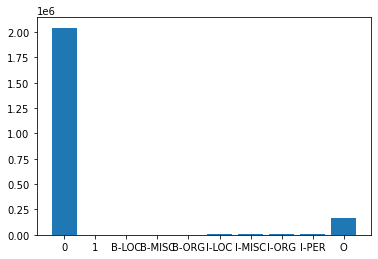

In [88]:
# Plot distribution of classes
plt.bar(x=range(len(target_counts)), height=target_counts);
plt.xticks(ticks=range(len(target_counts)), labels= [0,1] + ner);

From the bar chart, it's clear that there's a significant skew. This is a problem as most machine learning algorithms assume that the data is evenly distributed within the classes. As a result, our model becomes more biased towards predicting the majority class, $O$. There's significantly less data for the model to learn the patterns of the minority classes (the remaining ner tags).


In order to correct for this class imbalance, we can assign different weights to the majority and minority classes. To help us estimate class weights for our unbalanced dataset, we'll use a `sklearn.utils.class_weight` library function.

In [89]:
from sklearn import utils

In [90]:
weights = utils.class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(Y.flatten()), y=Y.flatten())

In [91]:
# Keras requires a dict for class_weight
class_weight = {i : weights[i] for i in range(9)}

By specifying `class_weight='balanced'`, the class weights will be calculated with the formula:
```
n_samples / (n_classes * np.bincount(y))
```

**UPDATE**: `class_weight` not supported for 3+ dimensional targets (see error in `fit()` below). We'll skip this optimisation for now.

##### Re-training with further improvements

We can try to improve our model's F1 score by making a few more adjustments. The previously-trained model weights can be loaded so that we only need to retrain for a few epochs.

In [103]:
# Loading our trained model
trained = True
if trained == False:
    model3.save_weights('model3.model')
else:
    model3.load_weights('model3.model')

##### Freezing weights

One strategy we have is to freeze the `Embedding` layer. If you were paying real close attention to the previous models, you might have noticed that we set this parameter to `True`. We can change this parameter to `False` to avoid updating the already learned weights during our re-training process. The randomly initialised layers in our model trigger a large gradient update during the training process which could interfere with the pre-trained `GloVe` embeddings.

In [104]:
model3.layers[0].trainable = False

##### Changing the optimiser

An additional step in our hyper-parameter tuning is to look at the `optimizer`. To save you some extra time, we will recommend which of the `keras.optimizers` we would go with and why. In [this](https://deepdatascience.wordpress.com/2016/11/18/which-lstm-optimizer-to-use/) comparison of frequently used optimisers, author Bikal Basnet found that the `nadam` optimiser had outperformed our previous optimiser, the `RMSprop`, in LSTM networks. Also, [this](https://ruder.io/optimizing-gradient-descent/index.html) great article by Sebastian Ruder has an animated visualisation of the optimisers on the loss surface as well as a detailed explanation of the `nadam` optimiser and the difference between it and `RMSprop`. We will specify a learning rate for our new optimiser, choosing value `0.001`. Feel free to play around with this hyperparameter and see if you achieve better results.

In [105]:
from keras import optimizers

In [106]:
model3.compile(optimizer=optimizers.Nadam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['acc'])

In [107]:
# Using class_weight
try:
    re_trained = False
    if re_trained == False:
        history = model3.fit(X, Y_train_cat, 
                             epochs=6, 
                             batch_size=BATCH_SIZE,
                             class_weight=class_weight,
                             validation_data=(X_dev_padded, Y_dev_cat))
    assert False
except Exception as e:
    print(f"{type(e).__name__}: {e}")

ValueError: `class_weight` not supported for 3+ dimensional targets.


In [108]:
re_trained = False
if re_trained == False:
    history = model3.fit(X, Y_train_cat, 
                         epochs=EPOCHS, 
                         batch_size=BATCH_SIZE,
                         validation_data=(X_dev_padded, Y_dev_cat))

Epoch 1/10
118/118 [==============================] - 206s 2s/step - loss: 0.0010 - acc: 0.9963 - val_loss: 0.0112 - val_acc: 0.9771
Epoch 2/10
118/118 [==============================] - 179s 2s/step - loss: 8.0336e-04 - acc: 0.9971 - val_loss: 0.0126 - val_acc: 0.9777
Epoch 3/10
118/118 [==============================] - 181s 2s/step - loss: 5.9775e-04 - acc: 0.9980 - val_loss: 0.0130 - val_acc: 0.9759
Epoch 4/10
118/118 [==============================] - 179s 2s/step - loss: 5.3505e-04 - acc: 0.9981 - val_loss: 0.0151 - val_acc: 0.9741
Epoch 5/10
118/118 [==============================] - 177s 1s/step - loss: 6.2274e-04 - acc: 0.9976 - val_loss: 0.0149 - val_acc: 0.9762
Epoch 6/10
118/118 [==============================] - 200s 2s/step - loss: 4.2067e-04 - acc: 0.9985 - val_loss: 0.0218 - val_acc: 0.9574
Epoch 7/10
118/118 [==============================] - 180s 2s/step - loss: 0.0019 - acc: 0.9946 - val_loss: 0.0145 - val_acc: 0.9769
Epoch 8/10
118/118 [=============================

##### Saving model weights

In [109]:
if re_trained == False:
    model3.save_weights('model3_1.model')
else:
    model3.load_weights('model3_1.model')

##### Visualising the training metrics
Now that we've trained our model, we want to visualise the model's training and validation accuracy.

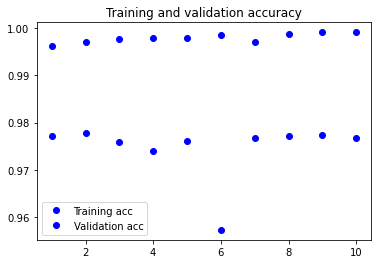

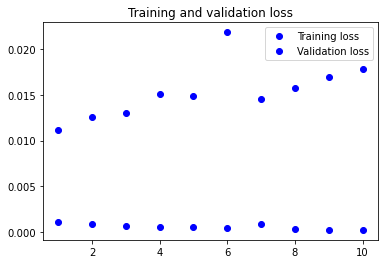

In [110]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'bo', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()


plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

_3. Apply your network to the test set and report the accuracy you obtained. You will use the `evaluate` method._

In [111]:
# Evaluates with the padding symbol
test_loss, test_acc = model3.evaluate(X_test_padded, Y_test_cat)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

116/116 [==============================] - 21s 178ms/step - loss: 0.0240 - acc: 0.9640
Test loss: 0.024024100974202156
Test accuracy: 0.9639566540718079


#### Evaluating your System
_1. Use the predict method to predict the tags of the whole test set._

In [112]:
y_pred = model3.predict(X_test_padded)
y_preds = np.argmax(y_pred, axis=2)

In [113]:
# Remove padding
Y_test_ = [y[y != 0.] for y in np.argmax(Y_test_cat, axis = 2)]
Y_pred_ = [y_hat[y != 0.] for y, y_hat in zip(np.argmax(Y_test_cat, axis = 2), y_preds)]

In [114]:
# Compare first predicted sentence tags to actual
print("Predicted:", Y_pred_[1])
print("Actual   :", Y_test_[1])

Predicted: [9 9 5 9 9 9 9 5 9 9 9 9]
Actual   : [9 9 5 9 9 9 9 8 9 9 9 9]


_2. Write your results in a file, where the two last columns will be the hand-annotated tag and the predicted tag. The fields must be separated by a space and each line must end with a new line: `\n`._

In [115]:
# Writing results to file
save("output3_1.txt", test_dict, ner, Y_test_, Y_pred_)

_3. Apply conlleval to your output. Report the F1 result._

In [116]:
lines = open("output3_1.txt", encoding='utf8').read().splitlines()
res = conlleval.evaluate(lines)
improved_score = res['overall']['chunks']['evals']['f1']
print("F1 score:", improved_score)

F1 score: 0.8203063457330416


## Credits
This assignment was prepared by _Pierre Nugues_, a phenomenal professor of Semantic Systems and Language Technology at Lunds Tekniska Högskola (bio [here](https://cs.lth.se/pierre/)).

Additional credits to [Christopher Marshall](https://medium.com/mysuperai/what-is-named-entity-recognition-ner-and-how-can-i-use-it-2b68cf6f545d) and [Guillamume Genthial](https://guillaumegenthial.github.io/sequence-tagging-with-tensorflow.html) for making my job of convincing you why NER is worth paying attention to a lot easier. 